# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline


In [2]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Begining of cleaning  in the display data set

In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
profile.shape

(17000, 5)

In [5]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [6]:
print(profile[profile['age']==118].count())

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64


In [7]:
profile[['gender','income','age']][profile['age']==118].head()

,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


We can deduce that he is using 118 nulls

In [8]:
new_clean_profile =profile.copy()

In [9]:
new_clean_profile['age']=new_clean_profile['age'].apply(lambda x: np.nan if x==118 else x)

In [10]:
new_clean_profile.head()

,gender,age,id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.dropna(inplace=True)

In [12]:
new_clean_profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(new_clean_profile['became_member_on'], format='%Y%m%d').dt.date
new_clean_profile['memberdays'] = new_clean_profile['memberdays'].dt.days

In [13]:
new_clean_profile.head()

,gender,age,id,became_member_on,income,memberdays
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1473
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1320
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,958
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1387
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,1300


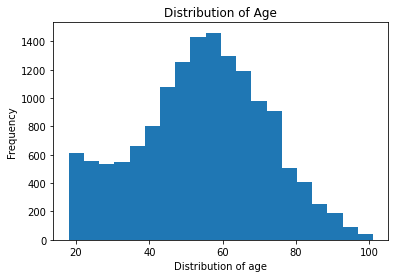

In [14]:
plt.figure()
new_clean_profile['age'].plot(kind='hist', bins=20, title='Distribution of Age')
plt.xlabel("Distribution of age");

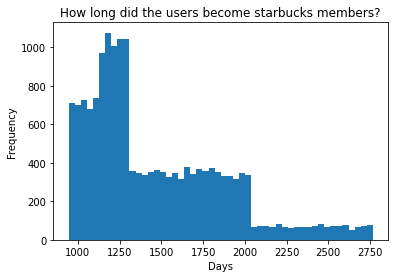

In [15]:
 plt.figure()
new_clean_profile['memberdays'].plot(kind='hist', bins=50, title='How long did the users become starbucks members?')
plt.xlabel("Days");

Text(0.5, 0, 'Income')

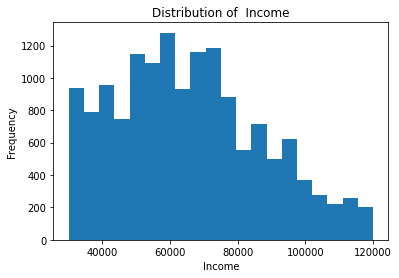

In [16]:
plt.figure()
new_clean_profile['income'].plot(kind='hist', bins=20, title='Distribution of  Income')
plt.xlabel("Income")

In [17]:
new_clean_profile.rename(columns={'id':'the_id'}, inplace=True)

# End of cleaning in the display data set

# Begining of cleaning in the Portfolio data set

# Portfolio.json

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [18]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [19]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [20]:
portfolio.id.nunique()

10

In [21]:
portfolio.id.unique()

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [22]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [23]:
portfolio.offer_type.nunique()

3

In [24]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [25]:
new_clean_portfolio =portfolio.copy()

In [26]:
new_clean_portfolio['duration'] = new_clean_portfolio['duration'] * 24 # this is used to change the duration into hours


In [27]:
new_clean_portfolio['web'] = new_clean_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
new_clean_portfolio['email'] = new_clean_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
new_clean_portfolio['mobile'] = new_clean_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
new_clean_portfolio['social'] = new_clean_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [28]:
offer_type = pd.get_dummies(new_clean_portfolio['offer_type'])


In [29]:
new_clean_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [30]:
offer_type.head()

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


In [31]:
new_clean_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)


In [32]:
new_clean_portfolio = pd.concat([new_clean_portfolio, offer_type], axis=1, sort=False)


In [33]:
new_clean_portfolio.head()

,reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


In [34]:
new_clean_portfolio.isnull().sum()

reward           0
difficulty       0
duration         0
id               0
web              0
email            0
mobile           0
social           0
bogo             0
discount         0
informational    0
dtype: int64

In [35]:
new_clean_portfolio.rename(columns={'id':'offer_id'}, inplace=True)


In [36]:
new_clean_portfolio.head()

,reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


# End of cleaning in the Portfolio data set

# Begining of cleaning in Transcrip dataset

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [37]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [38]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [39]:
transcript.event.nunique()

4

In [40]:
transcript.person.nunique()

17000

In [41]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [42]:
transcript.value[306529]

{'amount': 1.5899999999999999}

In [43]:
event_type = pd.get_dummies(transcript['event'])

In [44]:
event_type.head()

,offer completed,offer received,offer viewed,transaction
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [45]:
event_type['offer completed'].sum()

33579

In [46]:
transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},714
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714


In [47]:
offer = transcript.copy()

In [48]:
offer = offer[offer['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

In [49]:
offer

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},714,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4


In [50]:
offer.rename(columns={'person':'the_id'}, inplace=True)


# Merging the data sets

In [51]:
trans_prof = pd.merge(offer, new_clean_profile, on='the_id',
                          how="left")

In [52]:
df = pd.merge(trans_prof, new_clean_portfolio, on='offer_id',
                          how="left")

In [53]:
df.head()

,the_id,event,value,time,offer_id,gender,age,became_member_on,income,memberdays,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,20170509,100000.0,1387,5,5,168,1,1,1,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN,20170804,NaN,1300,5,20,240,1,1,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,M,68.0,20180426,70000.0,1035,2,10,168,1,1,1,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,None,NaN,20170925,NaN,1248,2,10,240,1,1,1,1,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,None,NaN,20171002,NaN,1241,10,10,120,1,1,1,1,1,0,0


In [54]:
df.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [55]:
offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'O0',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'O1',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'O2',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'O3',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'O4',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'O5',
                'fafdcd668e3743c1bb461111dcafc2a4': 'O6',
                '2906b810c7d4411798c6938adc9daaa5': 'O7',
                '3f207df678b143eea3cee63160fa8bed': 'O8',
                '5a8bc65990b245e5a138643cd4eb9837': 'O9'}
df.offer_id = df.offer_id.apply(lambda x: offer_id[x] if x else None)

In [56]:
df.head()

,the_id,event,value,time,offer_id,gender,age,became_member_on,income,memberdays,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,O2,F,75.0,20170509,100000.0,1387,5,5,168,1,1,1,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,O4,None,NaN,20170804,NaN,1300,5,20,240,1,1,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,O7,M,68.0,20180426,70000.0,1035,2,10,168,1,1,1,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,O6,None,NaN,20170925,NaN,1248,2,10,240,1,1,1,1,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,O1,None,NaN,20171002,NaN,1241,10,10,120,1,1,1,1,1,0,0


/home/mostafahaggag/Data_science_enviroment/data_science_enviroment/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


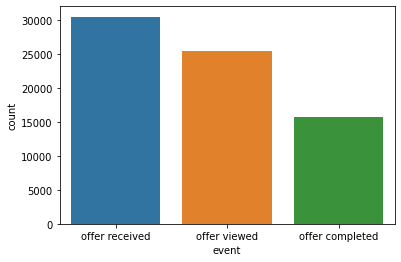

In [57]:
sns.countplot(df[df.bogo == 1].event);

/home/mostafahaggag/Data_science_enviroment/data_science_enviroment/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mostafahaggag/Data_science_enviroment/data_science_enviroment/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mostafahaggag/Data_science_enviroment/data_science_enviroment/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be

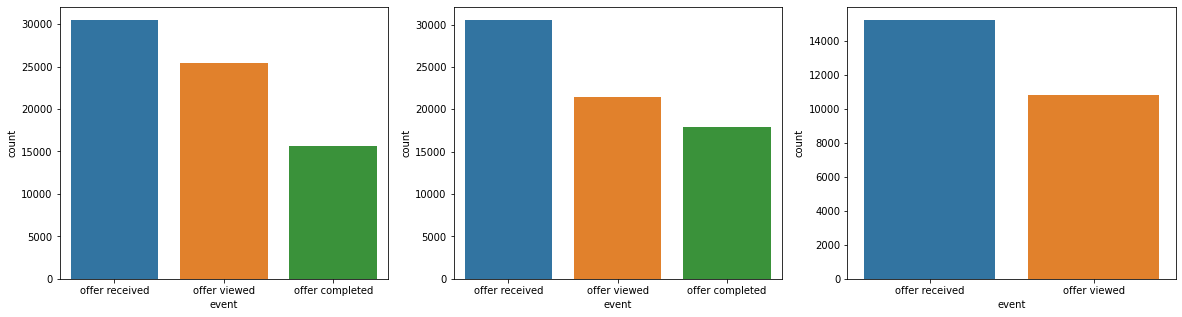

In [58]:
fig, ax =plt.subplots(1,3,figsize=(20,5))
sns.countplot(df[df.bogo == 1].event,ax=ax[0]);
sns.countplot(df[df.discount == 1].event,ax=ax[1]);
sns.countplot(df[df.informational == 1].event,ax=ax[2]);


/home/mostafahaggag/Data_science_enviroment/data_science_enviroment/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mostafahaggag/Data_science_enviroment/data_science_enviroment/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mostafahaggag/Data_science_enviroment/data_science_enviroment/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be

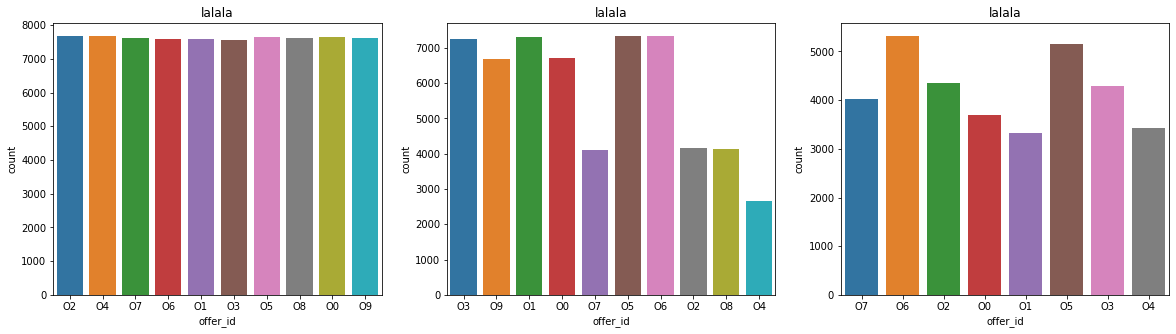

In [59]:
fig, ax =plt.subplots(1,3,figsize=(20,5))
sns.countplot(df[df.event == 'offer received'].offer_id,ax=ax[0]).set_title('lalala');
sns.countplot(df[df.event == 'offer viewed'].offer_id,ax=ax[1]).set_title('lalala');
sns.countplot(df[df.event == 'offer completed'].offer_id,ax=ax[2]).set_title('lalala');

In [60]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['the_id', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(new_clean_portfolio[new_clean_portfolio['informational']==1]['offer_id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        for the_id in user_item_matrix.index:
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['the_id']==the_id)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[the_id, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[the_id, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[the_id, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [64]:
#full_df = create_user_item_matrix(offer, 'full_data_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Now processing:  2906b810c7d4411798c6938adc9daaa5
Now processing:  4d5c57ea9a6940dd891ad53e9dbe8da0
Now processing:  9b98b8c7a33c4b65b9aebfe6a799e6d9
Now processing:  ae264e3637204a6fb9bb56bc8210ddfd
Now processing:  f19421c1d4aa40978ebb69ca19b0e20d
Now processing:  fafdcd668e3743c1bb461111dcafc2a4


In [65]:
full_df = pd.read_pickle('full_data_df.p')

In [61]:
train_size = int(offer.shape[0]*0.7)
test_size = offer.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [62]:
train_offer = offer[:train_size]

In [63]:
test_offer = offer[train_size:]

In [67]:
#train_df = create_user_item_matrix(train_offer, 'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Now processing:  2906b810c7d4411798c6938adc9daaa5
Now processing:  4d5c57ea9a6940dd891ad53e9dbe8da0
Now processing:  9b98b8c7a33c4b65b9aebfe6a799e6d9
Now processing:  ae264e3637204a6fb9bb56bc8210ddfd
Now processing:  f19421c1d4aa40978ebb69ca19b0e20d
Now processing:  fafdcd668e3743c1bb461111dcafc2a4


In [66]:
train_df = pd.read_pickle('train_df.p')

In [68]:
#test_df = create_user_item_matrix(test_offer, 'test_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Now processing:  2906b810c7d4411798c6938adc9daaa5
Now processing:  4d5c57ea9a6940dd891ad53e9dbe8da0
Now processing:  9b98b8c7a33c4b65b9aebfe6a799e6d9
Now processing:  ae264e3637204a6fb9bb56bc8210ddfd
Now processing:  f19421c1d4aa40978ebb69ca19b0e20d
Now processing:  fafdcd668e3743c1bb461111dcafc2a4


In [67]:
test_df = pd.read_pickle('test_df.p')

In [68]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [71]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.314854
2 		 0.267335
3 		 0.266970
4 		 0.266604
5 		 0.266233
6 		 0.265857
7 		 0.265476
8 		 0.265089
9 		 0.264696
10 		 0.264296
11 		 0.263890
12 		 0.263475
13 		 0.263053
14 		 0.262621
15 		 0.262180
16 		 0.261729
17 		 0.261267
18 		 0.260794
19 		 0.260307
20 		 0.259808
21 		 0.259294
22 		 0.258764
23 		 0.258218
24 		 0.257655
25 		 0.257072
26 		 0.256469
27 		 0.255845
28 		 0.255197
29 		 0.254525
30 		 0.253826
31 		 0.253099
32 		 0.252342
33 		 0.251553
34 		 0.250731
35 		 0.249872
36 		 0.248975
37 		 0.248038
38 		 0.247057
39 		 0.246031
40 		 0.244958
41 		 0.243834
42 		 0.242656
43 		 0.241423
44 		 0.240132
45 		 0.238779
46 		 0.237363
47 		 0.235879
48 		 0.234327
49 		 0.232703
50 		 0.231005
51 		 0.229231
52 		 0.227379
53 		 0.225446
54 		 0.223432
55 		 0.221335
56 		 0.219155
57 		 0.216889
58 		 0.214540
59 		 0.212106
60 		 0.209588
61 		 0.206988
62 		 0.204307
63 		 0.201548
64 		 0

In [72]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.297825
2 		 0.266292
3 		 0.265840
4 		 0.265372
5 		 0.264900
6 		 0.264427
7 		 0.263950
8 		 0.263471
9 		 0.262989
10 		 0.262504
11 		 0.262015
12 		 0.261522
13 		 0.261026
14 		 0.260525
15 		 0.260019
16 		 0.259508
17 		 0.258993
18 		 0.258471
19 		 0.257943
20 		 0.257409
21 		 0.256868
22 		 0.256319
23 		 0.255762
24 		 0.255197
25 		 0.254622
26 		 0.254038
27 		 0.253443
28 		 0.252837
29 		 0.252218
30 		 0.251587
31 		 0.250943
32 		 0.250283
33 		 0.249608
34 		 0.248917
35 		 0.248208
36 		 0.247481
37 		 0.246733
38 		 0.245965
39 		 0.245174
40 		 0.244359
41 		 0.243520
42 		 0.242654
43 		 0.241760
44 		 0.240837
45 		 0.239883
46 		 0.238896
47 		 0.237875
48 		 0.236818
49 		 0.235723
50 		 0.234590
51 		 0.233415
52 		 0.232197
53 		 0.230936
54 		 0.229628
55 		 0.228273
56 		 0.226869
57 		 0.225415
58 		 0.223909
59 		 0.222349
60 		 0.220736
61 		 0.219068
62 		 0.217343
63 		 0.215562
64 		 0

In [73]:
# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.278817
2 		 0.268381
3 		 0.267536
4 		 0.266686
5 		 0.265836
6 		 0.264985
7 		 0.264133
8 		 0.263280
9 		 0.262425
10 		 0.261570
11 		 0.260713
12 		 0.259855
13 		 0.258995
14 		 0.258134
15 		 0.257272
16 		 0.256408
17 		 0.255542
18 		 0.254674
19 		 0.253803
20 		 0.252931
21 		 0.252057
22 		 0.251179
23 		 0.250299
24 		 0.249416
25 		 0.248530
26 		 0.247640
27 		 0.246747
28 		 0.245850
29 		 0.244949
30 		 0.244043
31 		 0.243132
32 		 0.242216
33 		 0.241295
34 		 0.240367
35 		 0.239434
36 		 0.238494
37 		 0.237547
38 		 0.236592
39 		 0.235630
40 		 0.234659
41 		 0.233680
42 		 0.232691
43 		 0.231692
44 		 0.230683
45 		 0.229663
46 		 0.228632
47 		 0.227589
48 		 0.226534
49 		 0.225465
50 		 0.224384
51 		 0.223288
52 		 0.222177
53 		 0.221051
54 		 0.219910
55 		 0.218753
56 		 0.217579
57 		 0.216387
58 		 0.215179
59 		 0.213952
60 		 0.212707
61 		 0.211443
62 		 0.210160
63 		 0.208857
64 		 0

In [74]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and offers that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Offer Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        # print("Sorry, but a prediction cannot be made for this user-offer pair.  It looks like one of these items does not exist in our current database.")
    
        return None

In [75]:
def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [76]:
validation(test_df, user_mat, offer_mat)

0.33239350543646495


In [77]:
validation(test_df, user_mat_10, offer_mat_10)

0.3294259428965362


In [78]:
validation(test_df, user_mat_5, offer_mat_5)

0.3118228839898325


In [79]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

In [80]:

def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [81]:
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.49
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.35
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.35
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.33
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.13
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.01
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  -0.11
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  -0.15


Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


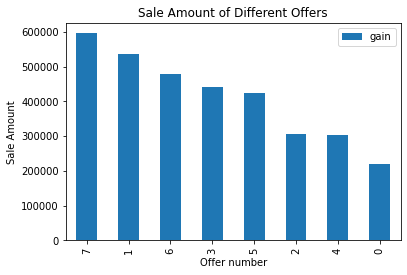

In [82]:
recommend_offer('new_user', user_mat, offer_mat)

In [83]:
def gender_offer(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # We count the number of offer completed base on the customer gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the total number of customers responsed our offers.
            gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

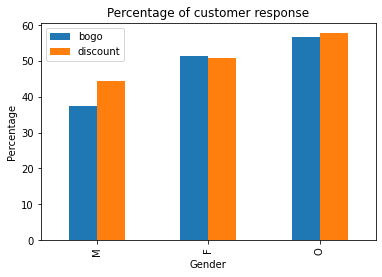

In [84]:
gender_offer(full_df)

In [91]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # We count the number of offer completed base on the customer gender
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in new_clean_portfolio[(new_clean_portfolio[channel_type]==1)&(new_clean_portfolio['informational']!=1)]['offer_id']:
            # count the total number of customers responsed our offers.
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

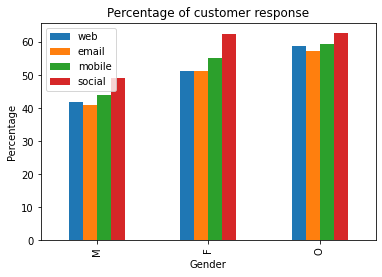

In [92]:
gender_offer_channel(full_df)

In [93]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])
    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94


,offer_id,gain
7,fafdcd668e3743c1bb461111dcafc2a4,596220.84
1,2298d6c36e964ae4a3e7e9706d1fb8c2,538027.98
6,f19421c1d4aa40978ebb69ca19b0e20d,480555.03
3,4d5c57ea9a6940dd891ad53e9dbe8da0,441918.93
5,ae264e3637204a6fb9bb56bc8210ddfd,423683.27
2,2906b810c7d4411798c6938adc9daaa5,305568.42
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,304361.77
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,218905.94


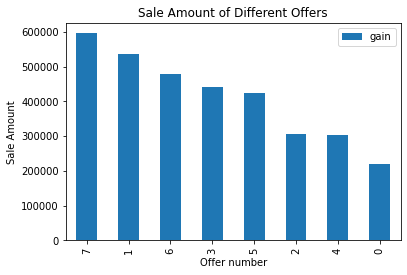

In [94]:
best_sale_offer(full_df)